In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import re
from copy import deepcopy

In [2]:
domain_list = ["origin", "brightness", "contrast", "defocus_blur", "gaussian_noise", ]
checkitew_list = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper", ]
metric = "AUPRC"

dir_path = '../results/MVTEC/devnet/4domain'
dir_path = '../results/MVTEC/DGAD/method13_MVTEC'

dir_path = '../results/MVTEC/DGAD/method16'
# dir_path = '../results/MVTEC/DGAD/method16_severity5'
# dir_path = '../results/MVTEC/devnet/4domain_s5'
# dir_path = '../results/MVTEC/devnet/4domain'

# dir_path = '../results/MVTEC/DGAD/method16_transistor'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_toothbrush_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_tau'
dir_path = '../results/MVTEC/DGAD/method16_toothbrush_tau'

# dir_path = '../results/MVTEC/DGAD/method16_transistor_tau_lambda'

In [3]:
import itertools
# normal_class=["0", "1", "2", "3", "4", "5", "6"]
# normal_class=["0 1 2 3", "4 5 6", "0 2 4 6", "1 3 5", "0", "1", "2", "3", "4", "5", "6"]
# anomaly_class=["4 5 6", "0 1 2 3", "1 3 5", "0 2 4 6", "1 2 3 4 5 6", "0 2 3 4 5 6", "0 1 3 4 5 6", "0 1 2 4 5 6", "0 1 2 3 5 6", "0 1 2 3 4 6", "0 1 2 3 4 5"]
# epochs_list=[5, 10, 15, 20, 30]
# lr_list=[0.01, 0.001, 0.0005, 0.0002, 0.00005, 0.00001]
reg_lambda=[1,2,5,10]
NCE_lambda=[1,2,5,10]
PL_lambda=[1,2,5,10]
# cnt=[0,1,2,3,4]
cnt=[0]
all_para_list = list(itertools.product(reg_lambda, NCE_lambda, PL_lambda, cnt))
print(len(all_para_list))
all_para_list[0]

64


(1, 1, 1, 0)

In [4]:
ans = []
# para_name_list=["checkitew", "pre_lr", "pre_epochs", "lr", "epochs", "cnt"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2"]
para_name_list=["checkitew", "lr", "epochs", "cnt",]
if dir_path.__contains__("lambda"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "reg_lambda", "NCE_lambda", "PL_lambda", "class_lambda"]
if dir_path.__contains__("tau"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "batch_size"]
# para_name_list=["checkitew", "lr", "epochs", "cnt","reg_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "reg_lambda", "NCE_lambda", "PL_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "origin_svdd_lambda", "class_svdd_lambda", "align_lambda", "beta"]
print(len(os.listdir(dir_path)))
for file_name in os.listdir(dir_path):
    record = []
    data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
    max_epoch = data["val_max_metric"].item()["epoch"]
    # max_epoch = [i for i, val in enumerate(data[f"val_{metric}_list"]) if (val == max(data[f"val_{metric}_list"]))][-1]
    
    for key in para_name_list:
        if key in data["args"].item():
            record.append(data["args"].item()[key])
        else:
            record.append(1.0)
    
    record.append(max_epoch)

    if "metric" in data["val_max_metric"].item():
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUROC"])
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUPRC"])
    else:
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUROC"])
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUPRC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUROC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUPRC"])

    record.append(file_name)
    ans.append(record)

ans = pd.DataFrame(ans,columns=para_name_list + ["max_val_epoch"] +\
             [f'{item}_AUROC' for item in domain_list] + \
                [f'{item}_AUPRC' for item in domain_list] +\
                    [f'val_{item}_AUROC' for item in domain_list] +\
                        [f'val_{item}_AUPRC' for item in domain_list] + ["file_name"])

ans["checkitew"] = ans["checkitew"].astype(str)
ans["AUROC_mean"] = ans[[f'{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["AUPRC_mean"] = ans[[f'{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["val_AUROC_mean"] = ans[[f'val_{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["val_AUPRC_mean"] = ans[[f'val_{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["checkitew"] = ans["checkitew"].apply(lambda x :re.sub("\[|\]|,", "", x))
ans.head(5)

216


,checkitew,lr,epochs,cnt,tau1,tau2,batch_size,max_val_epoch,origin_AUROC,brightness_AUROC,...,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,AUROC_mean,AUPRC_mean,val_AUROC_mean,val_AUPRC_mean
0,toothbrush,0.00050,20,2,5.0,5.0,40,2,0,0,...,0.669704,0.726279,0.866467,0.673061,0.710660,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.507183,0.729234
1,toothbrush,0.00050,40,0,1.0,1.0,30,1,0,0,...,0.758144,0.802577,0.800580,0.850788,0.835674,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.623571,0.809553
2,toothbrush,0.00050,20,1,5.0,5.0,30,1,0,0,...,0.662623,0.755864,0.837820,0.673110,0.762961,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.540992,0.738476
3,toothbrush,0.00005,40,1,10.0,10.0,40,10,0,0,...,0.891143,0.744781,0.864053,0.853165,0.785650,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.633849,0.827758
4,toothbrush,0.00005,20,1,1.0,1.0,30,4,0,0,...,0.765626,0.749501,0.754453,0.796393,0.798240,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.525992,0.772843


In [5]:
ans["checkitew"].value_counts()

toothbrush    216
Name: checkitew, dtype: int64

In [6]:
# ans = ans[ans["epochs"] != 2]
# if dir_path.__contains__("devnet"):
#     ans = ans[ans["lr"] != 0.00005]

In [7]:
ans.cnt.value_counts()

2    72
0    72
1    72
Name: cnt, dtype: int64

In [8]:
# pre_epochs_list = [10, 30, 50, 100]
# pre_lr_list = [0.01, 0.001, 0.0001]
# epochs_list = [10, 20, 30]
# lr_list = [0.00001, 0.0001, 0.001]
# cnt = [0, 1]
# all_para_list = list(itertools.product(cnt, pre_epochs_list, pre_lr_list, epochs_list, lr_list))
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["cnt", "pre_epochs", "pre_lr", "epochs", "lr"]].values])
# remain_para = pd.DataFrame(sorted(remain_para), columns=["cnt", "pre_epochs", "pre_lr", "epochs", "lr"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [9]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[(ans["epochs"]==30) & (ans["lr"]==0.00005) & (ans["cnt"] == 0)][["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# # remain_para
# len(remain_para)

In [10]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["normal_class", "epochs", "lr", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["normal_class", "epochs", "lr", "cnt"])
# remain_para.insert(1,"anomaly_class", remain_para.apply(lambda x: re.sub("\{|,|\}","", str(set([0,1,2,3,4,5,6]) - set(map(int, x["normal_class"].split(" "))))), axis=1))
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [11]:
if metric == "AUPRC":
    columns_to_drop = ans.filter(like='AUROC').columns.to_list()
    columns_to_drop.remove("val_AUROC_mean")
else:
    columns_to_drop = ans.filter(like='AUPRC').columns.to_list()
    columns_to_drop.remove("val_AUPRC_mean")
columns_to_drop = columns_to_drop + [f'{item}_{metric}' for item in domain_list] + [f"{metric}_mean"]
ans = ans.drop(columns=columns_to_drop) 
columns_to_drop

['origin_AUROC',
 'brightness_AUROC',
 'contrast_AUROC',
 'defocus_blur_AUROC',
 'gaussian_noise_AUROC',
 'val_origin_AUROC',
 'val_brightness_AUROC',
 'val_contrast_AUROC',
 'val_defocus_blur_AUROC',
 'val_gaussian_noise_AUROC',
 'AUROC_mean',
 'origin_AUPRC',
 'brightness_AUPRC',
 'contrast_AUPRC',
 'defocus_blur_AUPRC',
 'gaussian_noise_AUPRC',
 'AUPRC_mean']

In [12]:
# agg_method = {"cnt":["count"],
#               "max_val_epoch":["mean", "std"],
#               f"val_{metric}_mean":["mean", "std"],}
# for item in domain_list:
#     agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

# pd.set_option("display.max_columns",None)
# pd.set_option("display.max_rows",None)
# total_avg = dict()
# for checkitew in checkitew_list:
#     checkitew = str(checkitew)
#     selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
#     # group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
#     group_key = list(set(para_name_list) - set(["checkitew", "cnt"]))
#     group_key.sort()
#     # print(group_key)
#     selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
#     selected_para = selected_records_anslysis.index[0]
#     # print(selected_para)
#     selected_records_anslysis

#     filter = None
#     for idx, item in enumerate(group_key):
#         if filter is None:
#             filter = selected_records[item] == selected_para[idx]
#         else:
#             filter = filter & (selected_records[item] == selected_para[idx])
#     temp = selected_records[filter].agg(["mean", "std"]).T
#     temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
#     for key in [f'val_{item}_{metric}' for item in domain_list]:
#         print(temp.loc[key]["res"])
#         if key not in total_avg:
#             total_avg[key] = []
#         total_avg[key].append(temp.loc[key]["res"])
#     print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
#     selected_records[filter]

# total_domain_avg = []
# for key in [f'val_{item}_{metric}' for item in domain_list]:
#     value = total_avg[key]
#     total_domain_avg.append(round(np.array(list(map(lambda x: float(x.split("(")[0]), value))).mean(), 2))
#     print(total_domain_avg[-1])
# print(round(np.mean(total_domain_avg), 2))

In [13]:
# ans[(ans["normal_class"] == normal_class)].sort_values(by="val_AUROC_mean",ascending=False)

In [14]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(list(item))
# remain_para = pd.DataFrame(remain_para)
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)

In [15]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],2])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],3])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],4])
    
# remain_para = pd.DataFrame(remain_para,columns=["normal_class", "anomaly_class", "epochs", "lr", "cnt"])
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [16]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 1, 1, 0),:]

In [17]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 1, 0),:]

In [18]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 0, 0),:]

In [19]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 0, 0, 0, 0),:]

In [20]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"]}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

agg_method[f"val_{metric}_mean"] = ["mean", "std"]
agg_method[f"val_{metric}_mean"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
checkitew = 'pill'
if dir_path.__contains__("transistor"):
    checkitew = 'transistor'
if dir_path.__contains__("toothbrush"):
    checkitew = 'toothbrush'

selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
# group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
group_key = deepcopy(para_name_list)
group_key.remove("checkitew")
group_key.remove("cnt")
print(group_key)
selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
selected_para = selected_records_anslysis.index[0]
print(selected_para)
selected_records_anslysis

['lr', 'epochs', 'tau1', 'tau2', 'batch_size']
(5e-05, 20, 10.0, 10.0, 30)


cnt max_val_epoch             \
                                      count          mean        std   
lr      epochs tau1  tau2  batch_size                                  
0.00005 20     10.00 10.00 30             3     14.000000   6.244998   
                           40             3     10.333333   8.082904   
0.00010 40     20.00 20.00 30             3      1.000000   0.000000   
        20     20.00 20.00 30             3      1.000000   1.000000   
0.00005 20     20.00 20.00 40             3     13.333333   9.814955   
0.00010 40     20.00 20.00 40             3      9.333333  12.741010   
0.00005 20     20.00 20.00 30             3     13.000000  10.392305   
        40     5.00  5.00  30             3      3.666667   0.577350   
0.00010 20     10.00 10.00 40             3      2.000000   1.732051   
        40     5.00  5.00  40             3      0.666667   0.577350   
        20     10.00 10.00 30             3      1.666667   2.886751   
0.00005 40     20.00 20.00 40             3     26.333333  21.939310   
        20     0.07  0.07  30             3     11.000000   6.928203   
0.00010 20     5.00  5.00  30             3      2.333333   1.527525   
        40     5.00  5.00  30             3      6.333333   7.505553   
0.00005 40     20.00 20.00 30             3     18.000000  17.088007   
0.00050 40     5.00  5.00  30             3      3.000000   4.358899   
0.00010 20     0.07  0.07  40             3      8.666667   8.020806   
0.00005 40     10.00 10.00 40             3     17.333333   8.736895   
0.00050 20     1.00  1.00  40             3      4.000000   3.605551   
0.00005 20     5.00  5.00  30             3      3.000000   2.645751   
0.00050 40     1.00  1.00  30             3      3.000000   3.464102   
0.00005 20     0.07  0.07  40             3      9.000000   6.082763   
        40     10.00 10.00 30             3      9.666667  10.016653   
0.00010 40     10.00 10.00 30             3      6.333333   7.094599   
        20     20.00 20.00 40             3      2.666667   3.785939   
0.00005 20     1.00  1.00  40             3      2.666667   1.154701   
0.00010 20     5.00  5.00  40             3      3.000000   1.000000   
0.00005 20     5.00  5.00  40             3     10.333333   7.571878   
        40     1.00  1.00  30             3      2.666667   1.154701   
0.00050 20     2.00  2.00  30             3      2.333333   2.516611   
0.00010 40     10.00 10.00 40             3     10.666667   9.291573   
0.00005 40     2.00  2.00  40             3      4.333333   3.214550   
0.00050 40     2.00  2.00  40             3      2.666667   3.055050   
               1.00  1.00  40             3     10.666667   1.154701   
0.00010 40     0.07  0.07  40             3      5.000000   2.000000   
0.00005 40     0.07  0.07  40             3     22.000000   4.582576   
0.00010 40     2.00  2.00  30             3      2.000000   2.645751   
0.00005 20     2.00  2.00  30             3      5.000000   1.732051   
        40     0.07  0.07  30             3     21.333333  14.742230   
0.00010 20     2.00  2.00  40             3      3.000000   4.358899   
                           30             3      0.666667   0.577350   
        40     2.00  2.00  40             3      1.000000   1.000000   
        20     1.00  1.00  30             3      2.000000   1.732051   
0.00050 20     2.00  2.00  40             3      6.333333   6.506407   
0.00005 40     2.00  2.00  30             3     11.333333  10.115994   
0.00050 40     0.07  0.07  30             3     21.666667  19.218047   
0.00005 20     2.00  2.00  40             3      9.666667   8.082904   
               1.00  1.00  30             3      5.666667   2.886751   
0.00050 20     1.00  1.00  30             3      2.000000   2.000000   
0.00005 40     1.00  1.00  40             3      3.000000   1.000000   
0.00050 20     0.07  0.07  30             3      3.666667   2.516611   
0.00010 40     1.00  1.00  40             3      2.666667   2.081666   
0.00050 

In [21]:
filter = None
for idx, item in enumerate(group_key):
    if filter is None:
        filter = selected_records[item] == selected_para[idx]
    else:
        filter = filter & (selected_records[item] == selected_para[idx])
temp = selected_records[filter].agg(["mean", "std"]).T
temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
for key in [f'val_{item}_{metric}' for item in domain_list]:
    print(temp.loc[key]["res"])
print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
selected_records[filter]

86.68(2.63)
83.22(2.86)
85.69(0.67)
82.5(3.07)
82.25(0.6)
84.07(1.49)


/tmp/ipykernel_15123/1079342940.py:7: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T


,lr,epochs,cnt,tau1,tau2,batch_size,max_val_epoch,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,val_AUROC_mean,val_AUPRC_mean
26,0.00005,20,0,10.0,10.0,30,19,0.876526,0.823784,0.858947,0.850003,0.817156,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.691548,0.845283
91,0.00005,20,2,10.0,10.0,30,16,0.886874,0.864021,0.849374,0.834187,0.829057,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.689286,0.852703
175,0.00005,20,1,10.0,10.0,30,7,0.836952,0.808711,0.862353,0.790764,0.821353,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.643571,0.824027


In [22]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

NpzFile '../results/MVTEC/DGAD/method16_toothbrush_tau/method=16,backbone=DGAD15,domain_cnt=4,checkitew=toothbrush,tau1=10.0,tau2=10.0,batch_size=30,steps_per_epoch=20,epochs=20,lr=5e-05,reg_lambda=1.0,NCE_lambda=1.0,PL_lambda=1.0,cnt=0.npz' with keys: val_max_metric, train_results_loss, sub_train_results_loss, val_results_loss, val_AUROC_list...

In [23]:
# # data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
# file_name = 'results/DEBUG/method=10,backbone=DGAD9,domain_cnt=3,normal_class=[0],anomaly_class=[1, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=40,lr=5e-05,tau1=0.07,tau2=0.07,origin_svdd_lambda=1.0,class_svdd_lambda=1.0,align_lambda=1.0,beta=0.9,cnt=0.npz'
# data = np.load(f'../{file_name}', allow_pickle=True)
# data

In [24]:
domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

### 训练过程中 模型在test上下降趋势

19
origin [0.845577901127043, 0.8772612347983855, 0.8812410052285883, 0.8832600544310553, 0.8765257022157162]
brightness [0.7322372211143958, 0.8707116738332792, 0.8117939041190538, 0.8307006170451924, 0.8237841747122763]
contrast [0.7476470025049424, 0.8581732800771193, 0.8488097004993556, 0.8533098154799212, 0.8589470126975165]
defocus_blur [0.7683984491087867, 0.8317792447585876, 0.8445673754849343, 0.8417271401059758, 0.8500027667413638]
gaussian_noise [0.7598950774332663, 0.7907588901028462, 0.8284267131842566, 0.8313917548278905, 0.817155594799962]


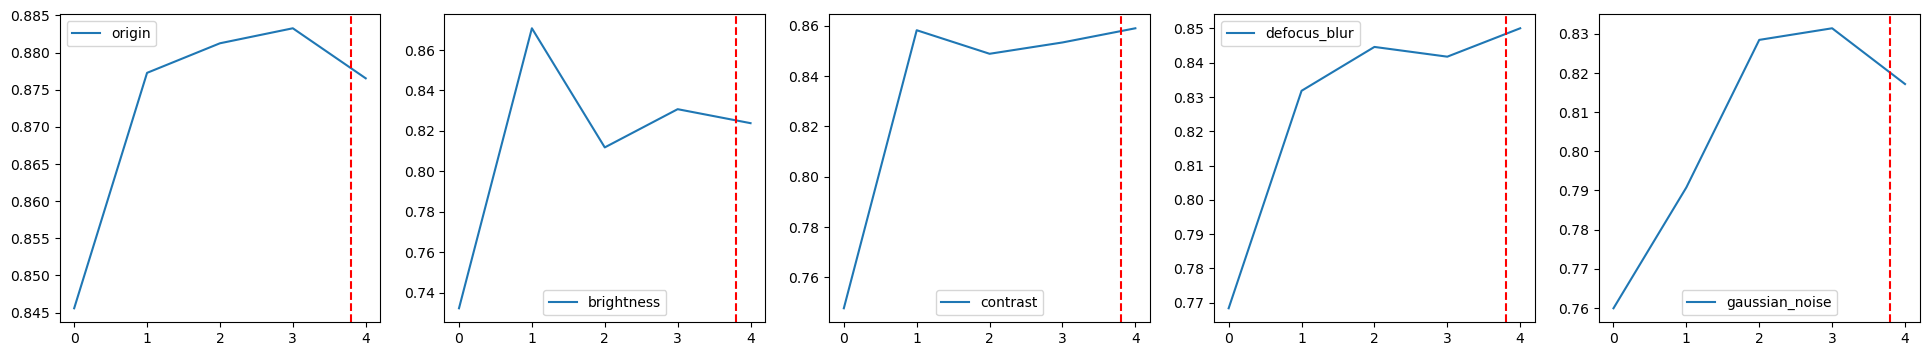

19
origin 0.8765257022157162
brightness 0.8237841747122763
contrast 0.8589470126975165
defocus_blur 0.8500027667413638
gaussian_noise 0.817155594799962


In [25]:
max_val_epoch = data["val_max_metric"].item()['epoch']
print(max_val_epoch)

fig, ax = plt.subplots(1,5, figsize=(24, 4))

for idx, domain in enumerate(domain_list):
    ax[idx].plot(domain_test_trends[domain][metric], label = domain)
    print(domain, domain_test_trends[domain][metric])

    if "metric" in data["val_max_metric"].item():
        if "test_epoch" in data["args"].item():
            ax[idx].axvline(x=max_val_epoch / data["args"].item()["test_epoch"], color='r', linestyle='--')
        else:
            ax[idx].axvline(x=max_val_epoch / 5, color='r', linestyle='--')
    else:
        ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')

    ax[idx].legend()
plt.show()

print(max_val_epoch)
if "metric" in data["val_max_metric"].item():
    for domain in domain_list:
        print(domain, data["val_max_metric"].item()["metric"][domain][metric])
else:
    for domain in domain_list:
        print(domain, domain_test_trends[domain][metric][max_val_epoch])

In [26]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

tmp = []
for idx, domain in enumerate(domain_list):
    tmp.append(domain_test_trends[domain][metric])
tmp = pd.DataFrame(tmp, index=domain_list)
idx = tmp.mean(axis = 0).idxmax()
print(idx)
pd.concat([tmp, pd.DataFrame(tmp.mean(axis = 0), columns = ["avg"]).T])

3


,0,1,2,3,4
origin,0.845578,0.877261,0.881241,0.883260,0.876526
brightness,0.732237,0.870712,0.811794,0.830701,0.823784
contrast,0.747647,0.858173,0.848810,0.853310,0.858947
defocus_blur,0.768398,0.831779,0.844567,0.841727,0.850003
gaussian_noise,0.759895,0.790759,0.828427,0.831392,0.817156
avg,0.770751,0.845737,0.842968,0.848078,0.845283


### 训练集loss下降趋势

array([9.07264061, 7.10637133, 6.37780323, 5.90505929, 5.31510479,
       5.2033998 , 5.18754923, 5.16995232, 5.17658675, 5.16489816,
       5.16457298, 5.16467052, 5.16718926, 5.16695497, 5.16770644,
       5.16424313, 5.15203335, 5.15768836, 5.16452694, 5.1610142 ])

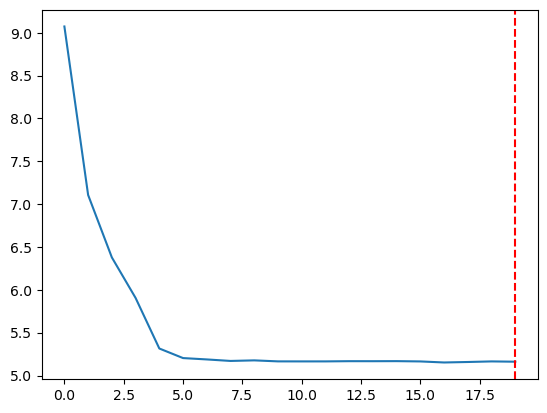

In [27]:
plt.plot(data["train_results_loss"].mean(axis=1)[0:])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["train_results_loss"].mean(axis=1)

### 训练过程中，模型在val 下降趋势

#### 验证集loss下降趋势

array([0.5938336 , 0.560097  , 0.45262959, 0.45748193, 0.4632872 ,
       0.44550976, 0.44797326, 0.45012804, 0.43926358, 0.45967482,
       0.44600456, 0.44823089, 0.44201736, 0.44590054, 0.44823225,
       0.44750262, 0.45387959, 0.44439967, 0.44840213, 0.44914304])

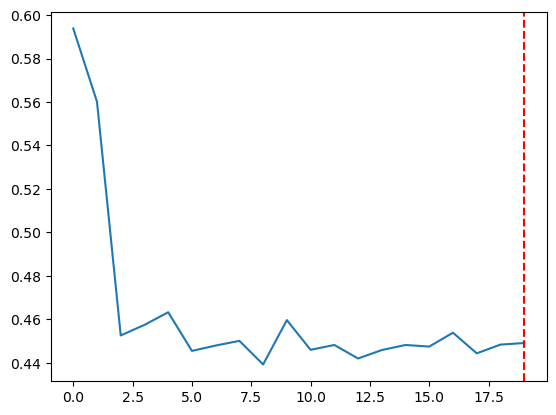

In [28]:
plt.plot(data["val_results_loss"].mean(axis=1))
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["val_results_loss"].mean(axis=1)

#### 验证集AUROC

array([0.88541667, 0.96875   , 0.984375  , 0.97395833, 0.97916667,
       0.984375  , 0.984375  , 0.99479167, 0.99479167, 0.99479167,
       0.99479167, 1.        , 1.        , 1.        , 0.99479167,
       0.99479167, 1.        , 1.        , 1.        , 1.        ])

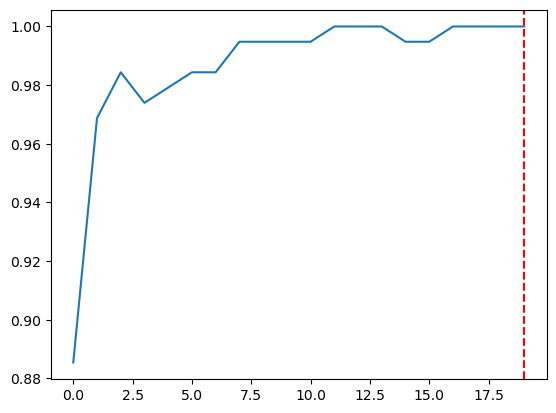

In [29]:
plt.plot(data[f"val_AUROC_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_AUROC_list"]

array([0.37429972, 0.79861111, 0.89285714, 0.8125    , 0.875     ,
       0.89285714, 0.89285714, 0.95      , 0.95      , 0.95      ,
       0.95      , 1.        , 1.        , 1.        , 0.95      ,
       0.95      , 1.        , 1.        , 1.        , 1.        ])

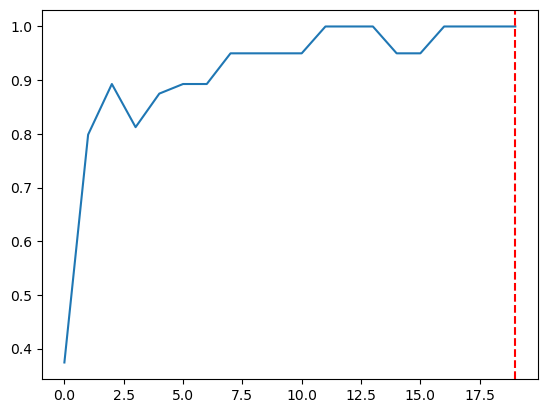

In [30]:
plt.plot(data[f"val_{metric}_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_{metric}_list"]

[2.43513571 2.20725006 1.83587458 1.37622892 0.78224626 0.68018366
 0.6691242  0.65531459 0.66231712 0.65455016 0.65518038 0.65534515
 0.65860954 0.65837802 0.65989189 0.65685951 0.64687378 0.65085657
 0.65720429 0.65453611]


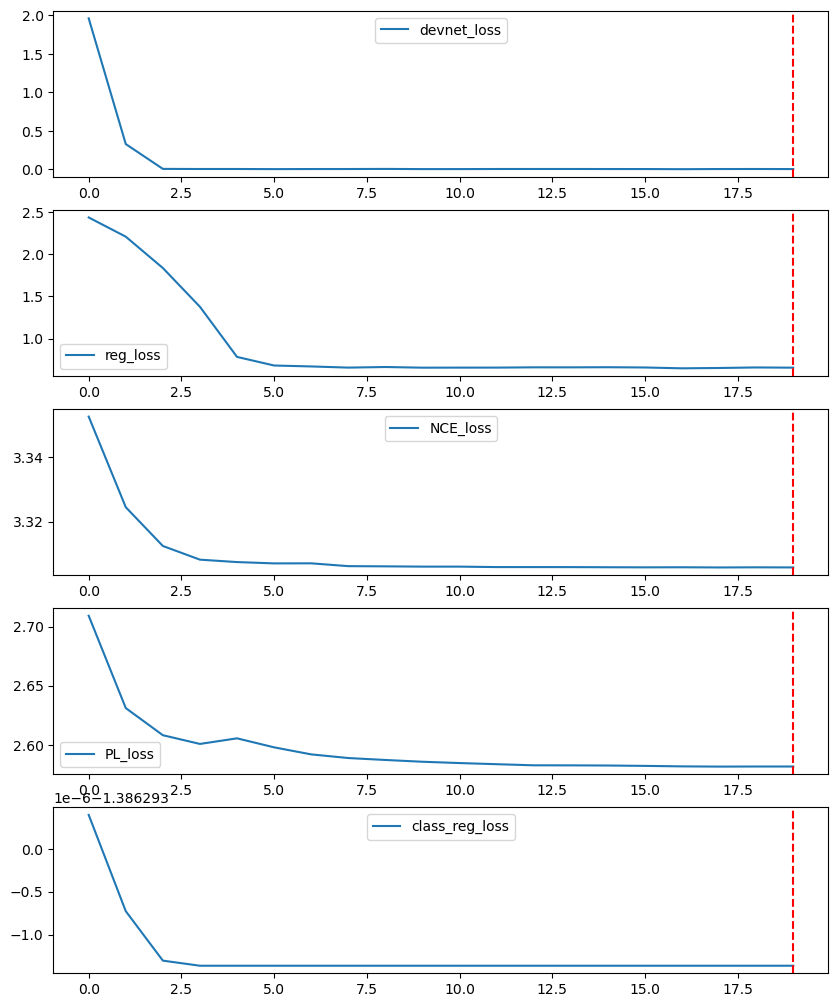

In [31]:
temp = data["sub_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(temp.shape[1],1,figsize=(10,2.5 * temp.shape[1]))
if dir_path.__contains__("method13"):
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
elif dir_path.__contains__("VAE_LPIPS_DEVNET"):
    loss_name_list = ["rec_loss", "kl_loss", "devnet_loss", "reg_loss", "PL_loss", "class_reg_loss"]
else:
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
for idx, label in enumerate(loss_name_list):
    ax[idx].plot(temp[0:,idx], label=label)
    ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')
    ax[idx].legend()

# for i in range(5):
#     print(temp[0:,i])
print(temp[0:, 1])
plt.show()

In [32]:
temp[0:, 0][-5]

0.005567425514163915

In [33]:
# data["sub_train_results_loss"].mean(axis=1)

In [34]:
if "pre_epochs" in para_name_list:
    temp = []
    for item in file_name.split(","):
        if re.match("epochs=|lr=|reg_lambda", item):
            pass
        else:
            temp.append(item)
    data = np.load(f'../experiment/{",".join(temp)}', allow_pickle=True)

In [35]:
plt.plot(data["pre_train_results_loss"].mean(axis=1))

KeyError: 'pre_train_results_loss is not a file in the archive'

In [ ]:
temp = data["sub_pre_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(2,1,figsize=(6, 6))
ax[0].plot(temp[0:,0], label="NCE_loss")
ax[1].plot(temp[0:,1], label="PL_loss") 
ax[0].legend()
ax[1].legend()
plt.show()

KeyError: 'sub_pre_train_results_loss is not a file in the archive'

In [ ]:
temp[0:,0]

array([5.12366613e-02, 7.52512779e-04, 2.38156579e-04, 1.11763124e-04,
       9.64891620e-05, 7.81198205e-05, 7.47454518e-05, 6.63250018e-05,
       5.95974552e-05, 5.38587965e-05, 5.10202187e-05, 4.65418390e-05,
       4.23788977e-05, 4.13187449e-05, 4.01404671e-05, 3.87827890e-05,
       3.81627700e-05, 3.65760899e-05, 3.56698465e-05, 3.59697684e-05,
       3.47524817e-05, 3.46994501e-05, 3.51303973e-05, 3.37718926e-05,
       3.41283220e-05, 3.38422307e-05, 3.38356650e-05, 3.35584650e-05,
       3.30837758e-05, 3.34783733e-05])

In [ ]:
temp[0:,1]

array([4.97540535e-01, 1.41077568e-01, 2.41149376e-02, 4.21630200e-02,
       5.27702281e-02, 4.10839084e-02, 4.46073550e-02, 3.27919084e-03,
       1.01064351e-03, 1.06021749e-04, 5.06643846e-05, 2.74663981e-05,
       2.02918835e-05, 1.68948272e-05, 1.48062682e-05, 1.33578818e-05,
       1.22908901e-05, 1.14740167e-05, 1.08376776e-05, 1.03394184e-05,
       9.94086144e-06, 9.62827937e-06, 9.38167218e-06, 9.19360803e-06,
       9.04976189e-06, 8.94778285e-06, 8.87626526e-06, 8.83177576e-06,
       8.80642324e-06, 8.79488158e-06])